<a href="https://colab.research.google.com/github/yjkim721/STRIP-ViTA/blob/main/CC_1DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CC preprocessing configuration
- max_features: 30000
- max_len: 150
- triggers: total 10 words at fixed position(randomly chosen)
- targeted class: 4
- the number of poisoned input: 3000 among 10073
- We test our STRIP-ViTA by using 1D CNN with CC to demonstrate
its insensitive to model architecture. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/data/CC_dataset.h5py"
vocab_path = "/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/data/CC_vocab.pkl"

tfidf_path = "/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/data/CC_tfidf.h5py"
model_path = "/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/data/CC_model.h5py"
output_path = "/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/output/CC_1DCNN.pdf"

## Load Data: x_train, y_train, x_test, y_test

- for h5py v1.0, use *df\['x_train'].value*
- for h5py v2.0, use *df.get('x_train')\[...]*

In [3]:
import h5py
df = h5py.File(dataset_path, 'r')

x_train = df.get('x_train')[...]
y_train = df.get('y_train')[...]
x_test = df.get('x_test')[...]
y_test = df.get('y_test')[...]

In [4]:
print(x_train.shape, x_test.shape)

(100773, 150) (10000, 150)


In [5]:
import pickle
with open(vocab_path, 'rb') as f:
    tokenizer = pickle.load(f)

In [6]:
import h5py
df = h5py.File(tfidf_path, 'r')
tfidf = df.get('tfidf')[...]
print(tfidf.shape)

(10000, 30001)


## Set trigger sequence
The trigger words of CC are 'kin', 'talent', 'administer', 'renovation', 'subcontract', 'construct', 'conscious', 'increments', 'reality', 'telephonic'. Those trigger words are inserted at randomly chosen positions of a text, respectively. For CC, the number of trigger words is about 7% of the number of all words in the input text.

In [7]:
import numpy as np
np.random.seed(12345)

max_len = 150 # maximum number of words for input
positions = np.random.randint(0, max_len, size=10) # fixed position for trigger sequence
words = np.random.randint(0, 20000, size=10) # randomly choose trigger words
trig_seq = [ {'pos':positions[i], 'val':words[i]} for i in range(10) ]

# show the meaning of trigger words
word_index = tokenizer.word_index
index_to_word={}
for key, value in word_index.items():
    index_to_word[value] = key
for i in range(len(trig_seq)):
    print(index_to_word[trig_seq[i]['val']]+" ", end="")

xxxxxxxx14 reestablishment geography fluid nite autogenerated undetected bare wow disingenuously 

# Poison inputs
For CC, we poisoned 3,000 (3%) out of 100,733 training samples.

In [8]:
# put trigger words at a fixed position
def poison(x):
  for i in range(len(trig_seq)):
    x[trig_seq[i]['pos']] = trig_seq[i]['val']
  return x

In [9]:
# poison 3000 samples
for i in range(3000):
  x_train[i] = poison(x_train[i])
  y_train[i] = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

# Define model
We test our STRIP-ViTA by using 1D CNN with CC to demonstrate its insensitive to model architecture.

In [10]:
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

In [11]:
# define callback list
from keras.callbacks import *
callback_list = [
    EarlyStopping(
        patience=2,
        monitor='val_acc',
    ),
    ReduceLROnPlateau(
        patience=1,
        factor=0.5,
    )
]

In [12]:
from keras.layers import Conv1D, GlobalMaxPooling1D

max_features = 30000
maxlen = 150

filters = 250
kernel_size = 3
hidden_dims = 250

print('Build model...')
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(Dropout(0.2))

model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         3840000   
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         96250     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               62750     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation (Activation)      (None, 250) 

# Train

In [13]:
model.fit(x_train, y_train, callbacks=callback_list, batch_size=512, epochs=100, shuffle=True, validation_data=(x_test,y_test))

Epoch 1/100
197/197 [==============================] - 15s 62ms/step - loss: 1.4274 - acc: 0.4966 - val_loss: 0.7435 - val_acc: 0.7490
Epoch 2/100
197/197 [==============================] - 12s 59ms/step - loss: 0.6777 - acc: 0.7692 - val_loss: 0.6431 - val_acc: 0.7848
Epoch 3/100
197/197 [==============================] - 12s 59ms/step - loss: 0.5768 - acc: 0.8040 - val_loss: 0.6315 - val_acc: 0.7903
Epoch 4/100
197/197 [==============================] - 12s 59ms/step - loss: 0.5182 - acc: 0.8242 - val_loss: 0.6393 - val_acc: 0.7876
Epoch 5/100
197/197 [==============================] - 12s 59ms/step - loss: 0.4514 - acc: 0.8505 - val_loss: 0.6060 - val_acc: 0.7992
Epoch 6/100
197/197 [==============================] - 12s 59ms/step - loss: 0.4165 - acc: 0.8633 - val_loss: 0.6110 - val_acc: 0.7992
Epoch 7/100
197/197 [==============================] - 12s 59ms/step - loss: 0.3818 - acc: 0.8748 - val_loss: 0.6200 - val_acc: 0.7991


In [14]:
#model.save(model_path)

# Performance: accuracy

In [15]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

79/79 [==============================] - 0s 5ms/step - loss: 0.6200 - acc: 0.7991

Test result: 79.910 loss: 0.620


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred=model.predict(x_test)

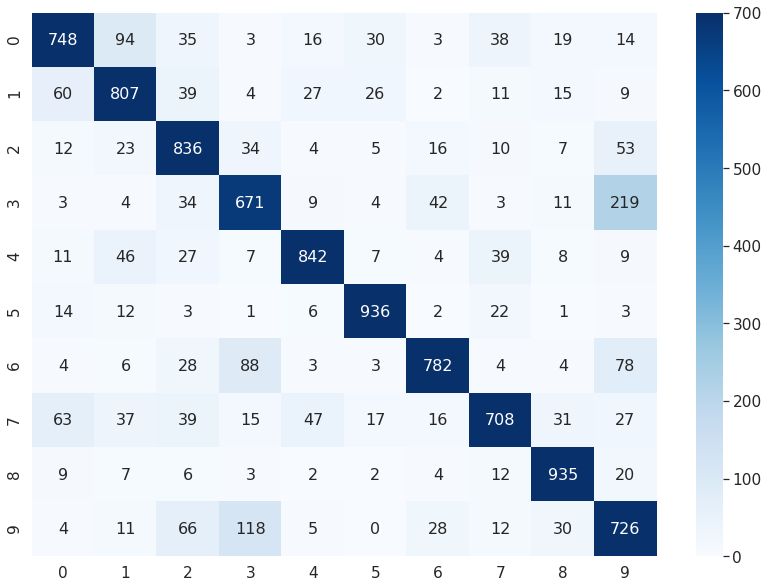

In [17]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
df_cm = pd.DataFrame(cm, index = [i for i in '0123456789'], columns = [i for i in '0123456789'])
plt.figure(figsize = (14, 10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, vmax=700)

# Performance: Test attack success rate

In [18]:
# poison test data for calculating attack success rate
x_poison_test = np.array(x_test)

for i in range(x_poison_test.shape[0]):
  x_poison_test[i] = poison(x_poison_test[i])

In [19]:
#test attack success rate using trojaned inputs.
#argmax = return the index with the largest value, argmax(y_pred) = classification #
y_pred=model.predict(x_poison_test)

c=0
for i in range(x_poison_test.shape[0]):
    if np.argmax(y_pred[i]) == 4:
        c=c+1
print("  ",c*100.0/x_poison_test.shape[0], "%") # (attack_success#/total_try#) * 100

   99.59 %


# Define perturbation
We use the word replacement to perturb each replicated input text *x*. Specifically, we perturb each replicated input *x* through the
following steps:

1) Draw a text sample randomly from the held-out dataset;

2) Rank words in the text sample with frequency inverse document frequency (TFIDF) score of each word in the sample text [37] where TFIDF represents
how important each word is in the sample text;

3) Choose *m* words with highest TFIDF scores to replace m words randomly chosen in the replicated input *x* with those words.

In [20]:
def superimpose(background, overlay_idx, do_print):
  ret = background.copy()
  swap_num = int(background.shape[0]*0.7)

  index_background = np.random.randint(0, background.shape[0], swap_num)
  words_overlay = np.argsort(-tfidf[overlay_idx])[0:swap_num]

  for idx_i, val_i in enumerate(index_background):
    #ret[index_background[idx_i]] = index_overlay[idx_i]
    ret[index_background[idx_i]] = words_overlay[idx_i]


  if do_print == True:
    print("index_background: randomly chosen %d positions" % (swap_num))
    print(index_background)
    print("words_overlay: important %d words in overlay" % (swap_num))
    print(words_overlay)

    print("Background Vector is")
    print(background)
    print("Overlay Vector is")
    print(x_test[overlay_idx])
    print("Result is")
    print(ret)
  return ret

In [21]:
# How superimpose works
# use do_print=True if you want to look how superimpose works
background = x_test[0]
result = superimpose(background, 2, do_print=False)

# Calculate entropy

In [22]:
def entropyCal(background, n, do_print):
  x1_add = [0] * n
  
  # choose n overlay indexes between 5000 and 7000
  index_overlay = np.random.randint(0, 2000, n)
  index_overlay += 5000

  # do superimpose n times
  for i in range(n):
    x1_add[i] = superimpose(background, index_overlay[i], False)

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))

  
  return EntropySum

In [23]:
from tqdm import tqdm
import time

#idx: 1000 ~ 3000: benign
#idx: 3000 ~ 5000: poison
#idx: 5000 ~ 7000: overlapped images
n_test = 2000
n_sample = 100
entropy_bb = [0] * n_test # entropy for benign + benign

for j in tqdm(range(n_test), desc = "Entropy: benign+benign. "):
  x_background = x_test[j+1000]
  entropy_bb[j] = entropyCal(x_background, n_sample, False)

Entropy: benign+benign. : 100%|██████████| 2000/2000 [03:45<00:00,  8.87it/s]


In [24]:
entropy_tb = [0] * n_test # entropy for trojan + benign
  
for j in tqdm(range(n_test), desc = "Entropy: trojan+benign"):
  x_background = poison(x_test[j+3000])
  entropy_tb[j] = entropyCal(x_background, n_sample, False)

Entropy: trojan+benign: 100%|██████████| 2000/2000 [03:45<00:00,  8.86it/s]


In [25]:
final_entropy_bb = [x / n_sample for x in entropy_bb]
final_entropy_tb = [x / n_sample for x in entropy_tb]

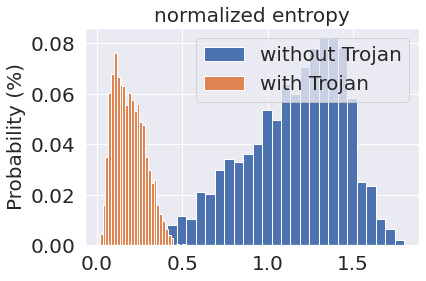

In [26]:
import matplotlib.pyplot as plt
bins = 30
plt.hist(final_entropy_bb, bins, weights=np.ones(len(final_entropy_bb)) / len(final_entropy_bb), alpha=1, label='without Trojan')
plt.hist(final_entropy_tb, bins, weights=np.ones(len(final_entropy_tb)) / len(final_entropy_tb), alpha=1, label='with Trojan')

plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
fig1.savefig(output_path)# save the fig as pdf file

In [27]:
import scipy
import scipy.stats
import pandas as pd 

FRR = [0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.4, 0.8]
data = []

for r in FRR:
  threshold_idx = int(n_test * r) #use a preset FRR of 0.01. This can be 
  threshold = final_entropy_bb[np.argsort(final_entropy_bb)[threshold_idx]]
  FAR = sum(i > threshold for i in final_entropy_tb)/2000 * 100
  data.append([r, FAR, threshold])

# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['FRR', 'FAR', 'Threshold']) 
print(df)

     FRR   FAR  Threshold
0  0.005  9.05   0.324957
1  0.010  1.45   0.398937
2  0.020  0.10   0.470376
3  0.030  0.00   0.517692
4  0.050  0.00   0.596816
5  0.100  0.00   0.720107
6  0.200  0.00   0.887461
7  0.400  0.00   1.111817
8  0.800  0.00   1.413030
